## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

### Установка зависимостей

In [66]:
!pip install -U torch torchvision

In [67]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
     |████████████████████████████████| 2.0 MB 4.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


7.1.2


In [72]:
import torch
from torch import optim
import numpy as np

from PIL import Image 

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score

import os
import pandas as pd
import time

from matplotlib import colors, patches, pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

# Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [6]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index, RESCALE_SIZE=256):
        transformers = {
            'train': 
            transforms.Compose([
                      transforms.RandomResizedCrop(size=RESCALE_SIZE),
                      transforms.RandomPerspective(distortion_scale=0.1),
                      transforms.RandomRotation(degrees=15),
                      transforms.ColorJitter(),
                      transforms.RandomHorizontalFlip(),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])            
            ]),
            'val':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
            ]),
            'test':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

        x = self.load_sample(self.files[index])

        if self.mode == 'train':
            x = transformers['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = transformers['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = transformers['test'](x)
            return x
        
    # def _prepare_sample(self, image):
    #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #     return np.array(image)

# Распределение классов

In [5]:
# Empty lists
traindir = '/content/gdrive/MyDrive/train/simpsons_dataset/'
categories = []
img_categories = []
n_train = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    n_train.append(len(train_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       }).sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)

In [7]:
cat_df.tail(10)

,category,n_train
34,rainier_wolfcastle,45
1,agnes_skinner,42
38,sideshow_mel,40
30,otto_mann,32
12,fat_tony,27
13,gil,27
26,miss_hoover,17
10,disco_stu,8
40,troy_mcclure,8
19,lionel_hutz,3


In [8]:
cat_df.to_csv('/content/cat_info.csv')

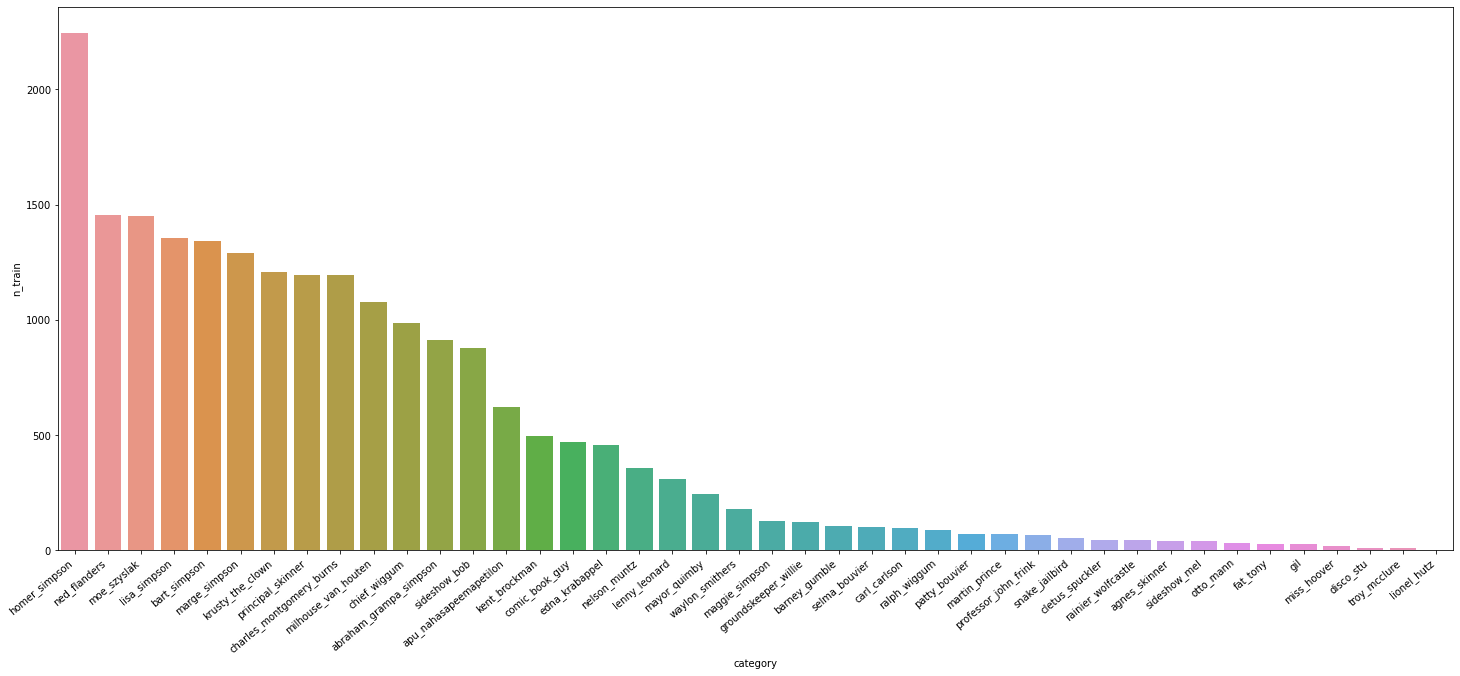

In [9]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(x = cat_df.category, y = cat_df.n_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
None

# Создание тренировочного, валидационного и тестового датасета

In [11]:
TRAIN_DIR = Path('/content/gdrive/MyDrive/train/simpsons_dataset')
TEST_DIR = Path('/content/gdrive/MyDrive/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
# different modes of dataset 
DATA_MODES = ['train', 'val', 'test']

# size for rescale
SIZE = 256

# set device
DEVICE = torch.device(device)

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify = train_val_labels, random_state = 1)

In [15]:
train_files_labels = [path.parent.name for path in train_files]
val_files_labels = [path.parent.name for path in val_files]

In [17]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode = 'val')
test_dataset = SimpsonsDataset(test_files, mode = 'test')

# Визуализация данных

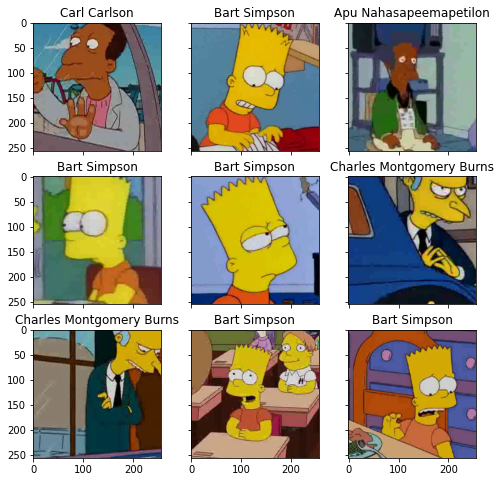

In [70]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Обучение

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data 
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval() 
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    val_loss = running_loss / processed_data 
    val_acc = running_corrects.cpu().numpy() / processed_data

    return val_loss, val_acc

In [24]:
def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    start = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} \n train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            scheduler.step()
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss,\
                                           t_acc=train_acc, v_acc=val_acc))
            
    alltime = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        alltime // 60, alltime % 60
    )) 
    print('Best val acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, history

In [26]:
def val_training(train_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    start = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            scheduler.step()

            history.append((train_loss, train_acc))

            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1,
                                           t_loss=train_loss, 
                                           t_acc=train_acc))
            
    alltime = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        alltime // 60, alltime % 60
    )) 
    print('Best val acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, history

In [27]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
def show_loss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(12, 8))
    plt.plot(loss, label="train")
    plt.plot(val_loss, label="val")
    plt.legend()
    plt.show()

# VGG_16

In [29]:
vgg_16 = models.vgg16(pretrained=True)
vgg_16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Finetuning

In [30]:
layers_to_unfreeze = 20
for param in vgg_16.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [31]:
num_features = 25088

n_classes = len(np.unique(train_val_labels))

vgg_16.classifier = nn.Sequential(
                    nn.Linear(in_features=num_features, out_features=4096, bias=True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(in_features=4096, out_features=4096, bias=True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(in_features=4096, out_features=n_classes)
)

vgg_16.to(DEVICE)

criterion_vgg = nn.CrossEntropyLoss()

optimizer_vgg = optim.AdamW(list(vgg_16.features.parameters())[-layers_to_unfreeze:] + 
                            list(vgg_16.classifier.parameters()), lr=3e-4)

scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [32]:
%%time
vgg_16, history = train(train_dataset, val_dataset, vgg_16, epochs=20, batch_size=64, 
                        criterion=criterion_vgg,
                        optimizer=optimizer_vgg,
                        scheduler=scheduler_vgg)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 3.1416043098804614


epoch:   5%|▌         | 1/20 [07:01<2:13:18, 421.00s/it]


Epoch 001 train_loss: 3.1416     val_loss 2.9739 
 train_acc 0.0981 val_acc 0.1318
loss 2.428350159704194


epoch:  10%|█         | 2/20 [13:57<2:05:33, 418.55s/it]


Epoch 002 train_loss: 2.4284     val_loss 1.2373 
 train_acc 0.3164 val_acc 0.6752
loss 1.5420258307306054


epoch:  15%|█▌        | 3/20 [20:49<1:57:39, 415.26s/it]


Epoch 003 train_loss: 1.5420     val_loss 0.7206 
 train_acc 0.5872 val_acc 0.8233
loss 1.2231699867258785


epoch:  20%|██        | 4/20 [27:40<1:50:19, 413.69s/it]


Epoch 004 train_loss: 1.2232     val_loss 0.5312 
 train_acc 0.6783 val_acc 0.8636
loss 1.049841617791866


epoch:  25%|██▌       | 5/20 [34:29<1:43:02, 412.19s/it]


Epoch 005 train_loss: 1.0498     val_loss 0.4609 
 train_acc 0.7195 val_acc 0.8870
loss 0.9614833960336098


epoch:  30%|███       | 6/20 [41:19<1:35:58, 411.33s/it]


Epoch 006 train_loss: 0.9615     val_loss 0.4256 
 train_acc 0.7498 val_acc 0.8959
loss 0.8854903744623309


epoch:  35%|███▌      | 7/20 [48:09<1:29:02, 410.93s/it]


Epoch 007 train_loss: 0.8855     val_loss 0.3499 
 train_acc 0.7668 val_acc 0.9164
loss 0.6862820826393436


epoch:  40%|████      | 8/20 [55:00<1:22:10, 410.85s/it]


Epoch 008 train_loss: 0.6863     val_loss 0.2746 
 train_acc 0.8176 val_acc 0.9384
loss 0.6499715968227922


epoch:  45%|████▌     | 9/20 [1:01:52<1:15:23, 411.19s/it]


Epoch 009 train_loss: 0.6500     val_loss 0.2612 
 train_acc 0.8268 val_acc 0.9453
loss 0.6137478875029005


epoch:  50%|█████     | 10/20 [1:08:45<1:08:37, 411.76s/it]


Epoch 010 train_loss: 0.6137     val_loss 0.2517 
 train_acc 0.8385 val_acc 0.9463
loss 0.6065497480454759


epoch:  55%|█████▌    | 11/20 [1:15:36<1:01:43, 411.52s/it]


Epoch 011 train_loss: 0.6065     val_loss 0.2476 
 train_acc 0.8405 val_acc 0.9475
loss 0.5836834854426441


epoch:  60%|██████    | 12/20 [1:22:26<54:48, 411.06s/it]


Epoch 012 train_loss: 0.5837     val_loss 0.2422 
 train_acc 0.8453 val_acc 0.9484
loss 0.565522980069966


epoch:  65%|██████▌   | 13/20 [1:29:16<47:56, 410.87s/it]


Epoch 013 train_loss: 0.5655     val_loss 0.2409 
 train_acc 0.8501 val_acc 0.9489
loss 0.5604136446841256


epoch:  70%|███████   | 14/20 [1:36:07<41:04, 410.71s/it]


Epoch 014 train_loss: 0.5604     val_loss 0.2336 
 train_acc 0.8537 val_acc 0.9484
loss 0.544913041909137


epoch:  75%|███████▌  | 15/20 [1:42:56<34:12, 410.43s/it]


Epoch 015 train_loss: 0.5449     val_loss 0.2287 
 train_acc 0.8578 val_acc 0.9503
loss 0.5329817181332314


epoch:  80%|████████  | 16/20 [1:49:47<27:21, 410.49s/it]


Epoch 016 train_loss: 0.5330     val_loss 0.2277 
 train_acc 0.8591 val_acc 0.9498
loss 0.5271683699922666


epoch:  85%|████████▌ | 17/20 [1:56:38<20:31, 410.54s/it]


Epoch 017 train_loss: 0.5272     val_loss 0.2291 
 train_acc 0.8592 val_acc 0.9508
loss 0.5329617296910465


epoch:  90%|█████████ | 18/20 [2:03:27<13:40, 410.22s/it]


Epoch 018 train_loss: 0.5330     val_loss 0.2288 
 train_acc 0.8567 val_acc 0.9498
loss 0.5244279756819947


epoch:  95%|█████████▌| 19/20 [2:10:15<06:49, 409.55s/it]


Epoch 019 train_loss: 0.5244     val_loss 0.2271 
 train_acc 0.8613 val_acc 0.9503
loss 0.5170020497672435


epoch: 100%|██████████| 20/20 [2:17:04<00:00, 411.21s/it]


Epoch 020 train_loss: 0.5170     val_loss 0.2280 
 train_acc 0.8622 val_acc 0.9513
Training complete in 137m 4s
Best val acc: 0.951278
CPU times: user 2h 7min 58s, sys: 2min 4s, total: 2h 10min 2s
Wall time: 2h 17min 4s


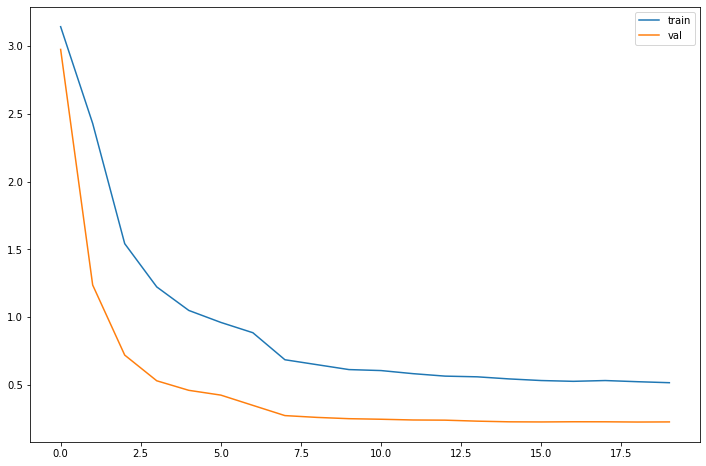

In [33]:
show_loss(history)

In [34]:
torch.save(vgg_16.state_dict(), 'vgg_16.pth')

In [36]:
!cp vgg_16.pth /content/gdrive/MyDrive

# MobileNetV3_small


In [37]:
from torchvision import models
mobNet = models.mobilenet_v3_small(pretrained=True)
mobNet

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [38]:
num_features = 576
n_classes = len(np.unique(train_files_labels))
mobNet.classifier = nn.Sequential(
                                  nn.Linear(num_features, 1024, bias=True),
                                  nn.Hardswish(),
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(1024, n_classes, bias=True) 
)

mobNet.to(DEVICE)

criterion_mobNet = nn.CrossEntropyLoss()

optimizer_mobNet = optim.AdamW(mobNet.parameters(), lr=3e-4)

scheduler_mobNet = lr_scheduler.StepLR(optimizer_mobNet, step_size=7, gamma=0.1)

In [ ]:
mobNet, history = train(train_dataset, val_dataset, mobNet, epochs=10, batch_size=64, 
                        criterion=criterion_mobNet,
                        optimizer=optimizer_mobNet,
                        scheduler=scheduler_mobNet
                        )

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.684627617016269


epoch:  10%|█         | 1/10 [03:40<33:02, 220.26s/it]


Epoch 001 train_loss: 1.6846     val_loss 0.5728 
 train_acc 0.5582 val_acc 0.8524
loss 0.8925898908700308


epoch:  20%|██        | 2/10 [07:17<29:06, 218.32s/it]


Epoch 002 train_loss: 0.8926     val_loss 0.3500 
 train_acc 0.7629 val_acc 0.9123
loss 0.6787213223973981


epoch:  30%|███       | 3/10 [10:53<25:20, 217.16s/it]


Epoch 003 train_loss: 0.6787     val_loss 0.2729 
 train_acc 0.8182 val_acc 0.9372
loss 0.6069659144166805


epoch:  40%|████      | 4/10 [14:28<21:38, 216.46s/it]


Epoch 004 train_loss: 0.6070     val_loss 0.2636 
 train_acc 0.8347 val_acc 0.9415
loss 0.5727536560998486


epoch:  50%|█████     | 5/10 [18:04<18:01, 216.22s/it]


Epoch 005 train_loss: 0.5728     val_loss 0.2295 
 train_acc 0.8465 val_acc 0.9465
loss 0.5273186836307598


epoch:  60%|██████    | 6/10 [21:41<14:26, 216.66s/it]


Epoch 006 train_loss: 0.5273     val_loss 0.2329 
 train_acc 0.8573 val_acc 0.9477
loss 0.4981630976113541


epoch:  70%|███████   | 7/10 [25:16<10:48, 216.16s/it]


Epoch 007 train_loss: 0.4982     val_loss 0.2098 
 train_acc 0.8647 val_acc 0.9506
loss 0.42458538940470236


epoch:  80%|████████  | 8/10 [28:51<07:11, 215.59s/it]


Epoch 008 train_loss: 0.4246     val_loss 0.1839 
 train_acc 0.8885 val_acc 0.9639
loss 0.4056344810856808


epoch:  90%|█████████ | 9/10 [32:25<03:35, 215.10s/it]


Epoch 009 train_loss: 0.4056     val_loss 0.1789 
 train_acc 0.8924 val_acc 0.9649


In [42]:
torch.save(mobNet.state_dict(), 'mobNetv3small.pth')

In [44]:
!cp mobNetv3small.pth /content/gdrive/MyDrive

# MobileNetV3_large

In [45]:
mobNetlarge = models.mobilenet_v3_large(pretrained=True)
mobNetlarge

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [46]:
num_features = 960
n_classes = len(np.unique(train_files_labels))
mobNetlarge.classifier = nn.Sequential(
                                  nn.Linear(num_features, 1280, bias=True),
                                  nn.Hardswish(),
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(1280, n_classes, bias=True) 
)

mobNetlarge.to(DEVICE)

criterion_mobNetlarge = nn.CrossEntropyLoss()

optimizer_mobNetlarge = optim.AdamW(mobNetlarge.parameters(), lr=3e-4)

scheduler_mobNetlarge = lr_scheduler.StepLR(optimizer_mobNetlarge, step_size=7, gamma=0.1)

In [47]:
mobNetlarge, history = train(train_dataset, val_dataset, mobNetlarge, epochs=15, batch_size=64, 
                        criterion=criterion_mobNetlarge,
                        optimizer=optimizer_mobNetlarge,
                        scheduler=scheduler_mobNetlarge
                        )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.323401026802366


epoch:   7%|▋         | 1/15 [04:19<1:00:36, 259.73s/it]


Epoch 001 train_loss: 1.3234     val_loss 0.3391 
 train_acc 0.6597 val_acc 0.9178
loss 0.7078000309289918


epoch:  13%|█▎        | 2/15 [08:34<55:40, 256.99s/it]


Epoch 002 train_loss: 0.7078     val_loss 0.2739 
 train_acc 0.8140 val_acc 0.9358
loss 0.549131350834481


epoch:  20%|██        | 3/15 [12:49<51:13, 256.13s/it]


Epoch 003 train_loss: 0.5491     val_loss 0.2179 
 train_acc 0.8534 val_acc 0.9503
loss 0.4799909741451674


epoch:  27%|██▋       | 4/15 [17:05<46:52, 255.72s/it]


Epoch 004 train_loss: 0.4800     val_loss 0.2045 
 train_acc 0.8711 val_acc 0.9558
loss 0.47544825628042137


epoch:  33%|███▎      | 5/15 [21:19<42:32, 255.24s/it]


Epoch 005 train_loss: 0.4754     val_loss 0.1917 
 train_acc 0.8771 val_acc 0.9613
loss 0.4372969171870756


epoch:  40%|████      | 6/15 [25:33<38:14, 254.98s/it]


Epoch 006 train_loss: 0.4373     val_loss 0.1710 
 train_acc 0.8797 val_acc 0.9661
loss 0.4010863879522684


epoch:  47%|████▋     | 7/15 [29:47<33:57, 254.66s/it]


Epoch 007 train_loss: 0.4011     val_loss 0.1683 
 train_acc 0.8926 val_acc 0.9680
loss 0.3297365844342268


epoch:  53%|█████▎    | 8/15 [34:02<29:41, 254.52s/it]


Epoch 008 train_loss: 0.3297     val_loss 0.1381 
 train_acc 0.9108 val_acc 0.9768
loss 0.2940351344679727


epoch:  60%|██████    | 9/15 [38:16<25:26, 254.47s/it]


Epoch 009 train_loss: 0.2940     val_loss 0.1383 
 train_acc 0.9212 val_acc 0.9759
loss 0.28420381559973107


epoch:  67%|██████▋   | 10/15 [42:30<21:11, 254.39s/it]


Epoch 010 train_loss: 0.2842     val_loss 0.1363 
 train_acc 0.9230 val_acc 0.9766
loss 0.2772910776751081


epoch:  73%|███████▎  | 11/15 [46:44<16:56, 254.15s/it]


Epoch 011 train_loss: 0.2773     val_loss 0.1342 
 train_acc 0.9244 val_acc 0.9764
loss 0.2613569735042741


epoch:  80%|████████  | 12/15 [50:57<12:42, 254.02s/it]


Epoch 012 train_loss: 0.2614     val_loss 0.1344 
 train_acc 0.9286 val_acc 0.9773
loss 0.2781449770231223


epoch:  87%|████████▋ | 13/15 [55:11<08:27, 253.87s/it]


Epoch 013 train_loss: 0.2781     val_loss 0.1323 
 train_acc 0.9237 val_acc 0.9761
loss 0.27662515795267884


epoch:  93%|█████████▎| 14/15 [59:25<04:13, 253.82s/it]


Epoch 014 train_loss: 0.2766     val_loss 0.1365 
 train_acc 0.9253 val_acc 0.9759
loss 0.2748623277681013


epoch: 100%|██████████| 15/15 [1:03:38<00:00, 254.56s/it]


Epoch 015 train_loss: 0.2749     val_loss 0.1341 
 train_acc 0.9260 val_acc 0.9771
Training complete in 63m 38s
Best val acc: 0.977311


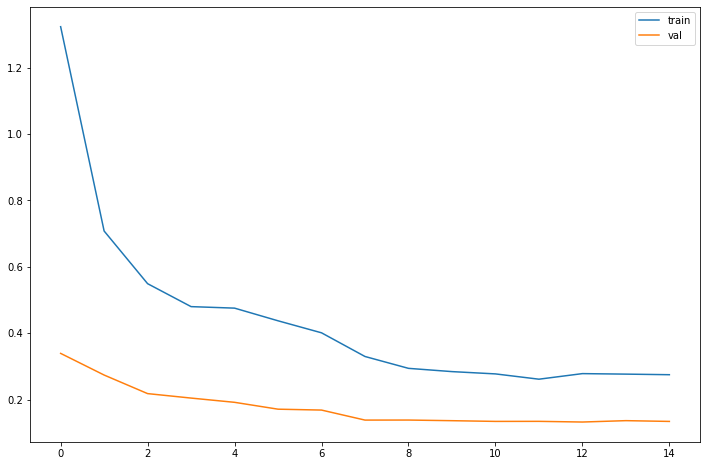

In [48]:
show_loss(history)

In [49]:
torch.save(mobNetlarge.state_dict(), 'mobNetLarge.pth')

In [51]:
!cp mobNetLarge.pth /content/gdrive/MyDrive

# Kaggle

In [53]:
def f1_val_score(num_samples, model):
  idxs = list(map(int, np.random.uniform(0, len(val_dataset), num_samples)))
  imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

  probs_ims = predict(model, imgs)

  y_pred = np.argmax(probs_ims,-1)
  actual_labels = [val_dataset[id][1] for id in idxs]

  return f1_score(actual_labels, y_pred, average='micro')

In [54]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [57]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [58]:
def submit(model, label_encoder, batch_size):
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  
  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  return my_submit

In [59]:
def save_pred(model, name):
    my_submit_mbnet_01 = submit(model, label_encoder, 64)
    my_submit_mbnet_01.to_csv('/content/{}.csv'.format(name), index=False)

vgg16

In [60]:
vgg_16.load_state_dict(torch.load('/content/vgg_16.pth'))

<All keys matched successfully>

In [61]:
print('f1_score vgg:', f1_val_score(1000, vgg_16))

f1_score vgg: 0.958


In [63]:
save_pred(vgg_16, 'submit_vgg16')

In [65]:
!cp submit_vgg16.csv /content/gdrive/MyDrive

mobileNet_v3_small

In [73]:
mobNet.load_state_dict(torch.load('/content/mobNetv3small.pth'))

<All keys matched successfully>

In [74]:
print('f1_score mobileNet_v3_small:', f1_val_score(1000, mobNet))

f1_score mobileNet_v3_small: 0.96


In [76]:
save_pred(mobNet, 'submit_mobnet')

In [77]:
!cp submit_mobnet.csv /content/gdrive/MyDrive

mobileNet_v3_large

In [78]:
mobNetlarge.load_state_dict(torch.load('/content/mobNetLarge.pth'))

<All keys matched successfully>

In [79]:
print('f1_score mobileNet_v3_large: ', f1_val_score(1000, mobNetlarge))

f1_score mobileNet_v3_large:  0.982


In [81]:
save_pred(mobNetlarge, 'submit_mobnetlarge')

In [82]:
!cp submit_mobnetlarge.csv /content/gdrive/MyDrive

kaggle score: 0.99681 Яна_Лысова_16538673